In [5]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [156]:
df = pd.read_csv('datasets/CNN_parameter_dataset.csv')
int_flow = df.copy()
int_flow.head()

,Sample,Cavity,Voltage,Flow rate,Duty cycle,Pulse width,Pulse period,Pulse pkpk,Pulse rms,Laser energy,cavity width(mm),cavity depth(µm)
0,5,6,25,0.47,20,4,20,3.132333,1.318667,0,2.285,72.1
1,5,7,25,0.47,20,4,20,3.010667,1.273267,0,2.199,68.2
2,5,8,25,0.47,20,4,20,3.329467,1.397467,0,2.108,67.2
3,5,9,25,0.47,20,4,20,3.260867,1.379214,0,2.233,61.2
4,5,10,25,0.47,20,4,20,3.198667,1.348800,0,2.046,52.2


In [157]:
#preparing the dataset for spliting into features and labels 
int_flow.columns = [col.strip() for col in df.columns]
int_flow.drop(['Sample','Cavity','Pulse width'], axis=1, inplace=True)
int_flow['cavity width(mm)'] = int_flow['cavity width(mm)']*1000
#int_flow = sklearn.utils.shuffle(int_flow)
int_flow.head()

,Voltage,Flow rate,Duty cycle,Pulse period,Pulse pkpk,Pulse rms,Laser energy,cavity width(mm),cavity depth(µm)
0,25,0.47,20,20,3.132333,1.318667,0,2285.0,72.1
1,25,0.47,20,20,3.010667,1.273267,0,2199.0,68.2
2,25,0.47,20,20,3.329467,1.397467,0,2108.0,67.2
3,25,0.47,20,20,3.260867,1.379214,0,2233.0,61.2
4,25,0.47,20,20,3.198667,1.348800,0,2046.0,52.2


In [158]:
X = int_flow.drop(['cavity width(mm)', 'cavity depth(µm)'], axis=1).values
#X = preprocessing.scale(X)
y = int_flow[['cavity width(mm)']].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=5)

In [159]:
X_train_1, X_dev, y_train_1, y_dev = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=5)

In [151]:
#defining a neural network model
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [160]:
#training the neuralnetwork model
X_train_1 = torch.tensor(X_train_1)
y_train_1 = torch.tensor(y_train_1)

X_dev = torch.tensor(X_dev)
y_dev = torch.tensor(y_dev)

X_train_1.shape, y_train_1.shape   

(torch.Size([62, 7]), torch.Size([62, 1]))

In [161]:
from tqdm import tqdm

net = Net()

loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.02)

# to track the training loss as the model trains
t_l = []
# to track the validation loss as the model trains
d_l = []

#initialize the early_stopping object
early_stopping = EarlyStopping(patience=100, verbose=True)

for epoch in tqdm(range(10000)):# 10000 full passes over the data        
    net.zero_grad() # sets gradients to 0 before loss calc. You will do this likely every step.
    output = net(X_train_1.float()) # pass in the training batch 
    loss = loss_function(output, y_train_1.float()) # calc and grab the loss value
    loss.backward() # apply this loss backwards thru the network's parameters
    optimizer.step() # attempt to optimize weights to account for loss/gradients
    if epoch%5 == 0: 
        with torch.no_grad():
            y_predict = net(X_dev.float())
            dev_error = loss_function(y_predict, y_dev.float())
            #print(f'train_loss..:{loss.item()} dev_loss..:{dev_error.item()} ')
            t_l.append(loss.item())
            d_l.append(dev_error.item())
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(dev_error, net)
            if early_stopping.early_stop:
                print("Early stopping")
                break  
            #print(loss) # print loss. We hope loss (train_loss..:{loss.item()} a measure of wrong-ness) declines!

  2%|█▍                                                                           | 180/10000 [00:00<00:10, 904.82it/s]

Validation loss decreased (inf --> 4878061.000000).  Saving model ...
Validation loss decreased (4878061.000000 --> 4860587.000000).  Saving model ...
Validation loss decreased (4860587.000000 --> 4811967.000000).  Saving model ...
Validation loss decreased (4811967.000000 --> 4688197.000000).  Saving model ...
Validation loss decreased (4688197.000000 --> 4417101.000000).  Saving model ...
Validation loss decreased (4417101.000000 --> 3918946.000000).  Saving model ...
Validation loss decreased (3918946.000000 --> 3133563.250000).  Saving model ...
Validation loss decreased (3133563.250000 --> 2093260.875000).  Saving model ...
Validation loss decreased (2093260.875000 --> 1049123.875000).  Saving model ...
Validation loss decreased (1049123.875000 --> 538236.000000).  Saving model ...
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 2 out of 100
Validation loss decreased (538236.000000 --> 434028.812500).  Saving model ...
Validation loss decreased (434028.812500 --> 392429

  4%|██▊                                                                          | 371/10000 [00:00<00:10, 910.78it/s]

Validation loss decreased (241832.015625 --> 239896.250000).  Saving model ...
Validation loss decreased (239896.250000 --> 237953.421875).  Saving model ...
Validation loss decreased (237953.421875 --> 235999.109375).  Saving model ...
Validation loss decreased (235999.109375 --> 234028.421875).  Saving model ...
Validation loss decreased (234028.421875 --> 232040.906250).  Saving model ...
Validation loss decreased (232040.906250 --> 230038.140625).  Saving model ...
Validation loss decreased (230038.140625 --> 228020.500000).  Saving model ...
Validation loss decreased (228020.500000 --> 225985.765625).  Saving model ...
Validation loss decreased (225985.765625 --> 223932.468750).  Saving model ...
Validation loss decreased (223932.468750 --> 221860.187500).  Saving model ...
Validation loss decreased (221860.187500 --> 219769.468750).  Saving model ...
Validation loss decreased (219769.468750 --> 217660.390625).  Saving model ...
Validation loss decreased (217660.390625 --> 215532.

  5%|███▋                                                                        | 491/10000 [00:00<00:09, 1012.78it/s]

Validation loss decreased (170495.968750 --> 168299.796875).  Saving model ...
Validation loss decreased (168299.796875 --> 166138.703125).  Saving model ...
Validation loss decreased (166138.703125 --> 164018.156250).  Saving model ...
Validation loss decreased (164018.156250 --> 161944.000000).  Saving model ...
Validation loss decreased (161944.000000 --> 159921.812500).  Saving model ...
Validation loss decreased (159921.812500 --> 157957.171875).  Saving model ...
Validation loss decreased (157957.171875 --> 156055.515625).  Saving model ...
Validation loss decreased (156055.515625 --> 154222.031250).  Saving model ...
Validation loss decreased (154222.031250 --> 152461.390625).  Saving model ...
Validation loss decreased (152461.390625 --> 150777.859375).  Saving model ...
Validation loss decreased (150777.859375 --> 149175.140625).  Saving model ...
Validation loss decreased (149175.140625 --> 147656.015625).  Saving model ...
Validation loss decreased (147656.015625 --> 146222.

  7%|█████▎                                                                       | 696/10000 [00:00<00:09, 959.59it/s]

Validation loss decreased (130982.320312 --> 130846.703125).  Saving model ...
Validation loss decreased (130846.703125 --> 130810.296875).  Saving model ...
Validation loss decreased (130810.296875 --> 130790.335938).  Saving model ...
Validation loss decreased (130790.335938 --> 130670.390625).  Saving model ...
Validation loss decreased (130670.390625 --> 130603.375000).  Saving model ...
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 2 out of 100
Validation loss decreased (130603.375000 --> 130586.312500).  Saving model ...
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 3 out of 100
EarlyStopping counter: 4 out of 100
EarlyStopping counter: 5 out of 100
EarlyStopping counter: 6 out of 100
EarlyStopping counter: 7 out of 100
EarlyStopping counter: 8 out of 100
EarlyStopping counter: 9 out of 100
EarlyStopping counter: 10 out of 100
EarlyStopping counter: 11 out of 100
EarlyStopping counter: 12 out of 100
EarlyStopping count

 10%|███████▎                                                                    | 968/10000 [00:00<00:07, 1165.81it/s]

EarlyStopping counter: 33 out of 100
EarlyStopping counter: 34 out of 100
EarlyStopping counter: 35 out of 100
EarlyStopping counter: 36 out of 100
EarlyStopping counter: 37 out of 100
EarlyStopping counter: 38 out of 100
EarlyStopping counter: 39 out of 100
EarlyStopping counter: 40 out of 100
EarlyStopping counter: 41 out of 100
EarlyStopping counter: 42 out of 100
EarlyStopping counter: 43 out of 100
EarlyStopping counter: 44 out of 100
EarlyStopping counter: 45 out of 100
EarlyStopping counter: 46 out of 100
EarlyStopping counter: 47 out of 100
EarlyStopping counter: 48 out of 100
EarlyStopping counter: 49 out of 100
EarlyStopping counter: 50 out of 100
EarlyStopping counter: 51 out of 100
EarlyStopping counter: 52 out of 100
EarlyStopping counter: 53 out of 100
EarlyStopping counter: 54 out of 100
EarlyStopping counter: 55 out of 100
EarlyStopping counter: 56 out of 100
EarlyStopping counter: 57 out of 100
EarlyStopping counter: 58 out of 100
EarlyStopping counter: 59 out of 100
E

 11%|████████▍                                                                  | 1130/10000 [00:01<00:08, 1074.97it/s]

EarlyStopping counter: 87 out of 100
EarlyStopping counter: 88 out of 100
EarlyStopping counter: 89 out of 100
EarlyStopping counter: 90 out of 100
EarlyStopping counter: 91 out of 100
EarlyStopping counter: 92 out of 100
EarlyStopping counter: 93 out of 100
EarlyStopping counter: 94 out of 100
EarlyStopping counter: 95 out of 100
EarlyStopping counter: 96 out of 100
EarlyStopping counter: 97 out of 100
EarlyStopping counter: 98 out of 100
EarlyStopping counter: 99 out of 100
EarlyStopping counter: 100 out of 100
Early stopping


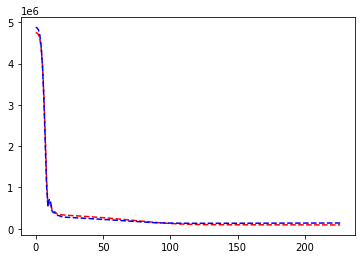

In [162]:
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
#t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t_l,'r--', d_l,'b--')
plt.show()

In [163]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

y_predict_1 = net(X_test.float())
error = loss_function(y_predict_1, y_test.float())

print(error.item())
for a in (list(zip(y_test,y_predict_1))):
    print(a)
    
print(r2_score(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

print('MAPE for width: ', mean_absolute_percentage_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

print('MSE for width: ', mean_squared_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

92096.5625
(tensor([2570.], dtype=torch.float64), tensor([2518.3364], grad_fn=<UnbindBackward0>))
(tensor([2449.], dtype=torch.float64), tensor([2301.2493], grad_fn=<UnbindBackward0>))
(tensor([1895.], dtype=torch.float64), tensor([2648.0896], grad_fn=<UnbindBackward0>))
(tensor([2411.], dtype=torch.float64), tensor([2230.8508], grad_fn=<UnbindBackward0>))
(tensor([3055.], dtype=torch.float64), tensor([2642.9304], grad_fn=<UnbindBackward0>))
(tensor([2078.], dtype=torch.float64), tensor([2543.8787], grad_fn=<UnbindBackward0>))
(tensor([831.], dtype=torch.float64), tensor([1080.5856], grad_fn=<UnbindBackward0>))
(tensor([1494.], dtype=torch.float64), tensor([1527.8843], grad_fn=<UnbindBackward0>))
(tensor([2538.], dtype=torch.float64), tensor([2582.1604], grad_fn=<UnbindBackward0>))
(tensor([2443.], dtype=torch.float64), tensor([2543.4436], grad_fn=<UnbindBackward0>))
(tensor([2380.], dtype=torch.float64), tensor([2329.7830], grad_fn=<UnbindBackward0>))
(tensor([2430.], dtype=torch.floa

In [15]:
import os, pathlib, random

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader



class EarlyStopping:
	"""Early stops the training if validation loss doesn't improve after a given patience."""
	def __init__(self, patience, verbose=False, delta=0, save_path='checkpoint.pt'):
		"""
		Args:
			patience (int): How long to wait after last time validation loss improved.
							Default: 7
			verbose (bool): If True, prints a message for each validation loss improvement.
							Default: False
			delta (float): Minimum change in the monitored quantity to qualify as an improvement.
							Default: 0
		"""
		self.patience = patience
		self.verbose = verbose
		self.counter = 0
		self.best_score = None
		self.early_stop = False
		self.val_loss_min = np.inf
		self.delta = delta
		self.save_path = save_path
		os.makedirs(pathlib.Path(self.save_path).parent, exist_ok=True)

	def __call__(self, val_loss, model):

		score = -val_loss

		if self.best_score is None:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
		elif score < self.best_score - self.delta:
			self.counter += 1
			print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
			if self.counter >= self.patience:
				self.early_stop = True
		else:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
			self.counter = 0

	def save_checkpoint(self, val_loss, model):
		"""Saves model when validation loss decrease."""
		if self.verbose:
			print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
		torch.save(model.state_dict(), self.save_path)
		self.val_loss_min = val_loss

In [146]:
X_train_1

tensor([[1.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 1.8129e+00, 1.2348e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.5266e+00, 1.6963e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.1053e+00, 1.4225e+00,
         0.0000e+00],
        [2.0000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 7.1144e-01, 4.9267e-01,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.6967e-01, 1.7533e-01,
         5.0000e+01],
        [2.5000e+01, 4.7000e-01, 2.0000e+01, 2.0000e+01, 3.2609e+00, 1.3792e+00,
         0.0000e+00],
        [3.0000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.8456e+00, 1.8818e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 5.0000e+01, 2.3254e+00, 1.6061e+00,
         0.0000e+00],
        [3.0000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.3681e+00, 1.6029e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.6037e+00, 1.75